In [1]:
# !/usr/local/bin/pip3.9 install seaborn
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from scipy.stats import chi2_contingency, chi2, ttest_ind, ttest_ind_from_stats, norm, binom, t
from statsmodels.stats.proportion import proportion_confint
np.random.seed(1)

In [3]:
def calculate_n(u, t, k):
    ns = ( ((t + (k - 1)*u)/k) * (1 - (t + (k - 1)*u)/k) ) / ( (t*(1-t) )/k)**2
    return ns


def vertical_plot_lines(x, xal, yal, **kwargs):
    plt.axvline(x.mean(), linestyle = '--', color = kwargs.get("color", "g"), alpha = 0.5)
    tx_mean = "mean: {:.3f}".format(x.mean())
    txkw = dict(size=11, color = kwargs.get("color", "g"), rotation=90)
    plt.text(x.mean()+xal, yal, tx_mean, **txkw)
    
    
def const_line(*args, **kwargs):
    x = np.arange(1, max_k, .01)
    y = x**2
    plt.plot(x, y, color='tomato', alpha=0.5, label='k^2')
    
    
def get_g_test(counts_base, counts_var, obs_base, obs_var):
    try:
        p_value = chi2_contingency(
            [[counts_base, counts_var], [obs_base - counts_base, obs_var - counts_var]], 
            correction = False, lambda_='log-likelihood'
        )[1]
    except ValueError:
        p_value = [nan]
    return p_value


def get_pval_per_k(k,k_factor, n_trials, p_t_b , p_t_v, p_u, sample_size):
    sample_size_o = int(sample_size*(k**k_factor))
    sample_treated_base_o = np.random.binomial(n=n_trials, p=(p_t_b + (k-1)*p_u)/k, size=sample_size_o)
    sample_treated_variant_o = np.random.binomial(n=n_trials, p=(p_t_v + (k-1)*p_u)/k, size=sample_size_o)
    p_val = get_g_test(counts_base=sample_treated_base_o.sum(), 
           counts_var=sample_treated_variant_o.sum(), 
           obs_base=sample_size_o,
           obs_var=sample_size_o)

    
    return p_val

# Simulations
## Simulate $n'/n_o$ as a function of $k$

In [4]:
max_k = 10
binary_param_vals = [i/10 for i in range(0,10,2)]
k_vals = [i/100 for i in range(100,max_k*100,1)]
results = []
for u,t in product(binary_param_vals, binary_param_vals):
    if t==0:
        continue
        
    for k in k_vals:
        n_vals = {
            'P_u': u,
            'P_t': t,
            'k': k,
            'n_tag': calculate_n(u, t, k=k),
            'n': calculate_n(u, t, k=1),
        }
        results.append(n_vals)
            
df = pd.DataFrame(results)
df['n_ratio'] = df['n_tag'] / df['n']
df['S_t'] = np.round( df['P_t'] * (1 - df['P_t']), 3)
df['S_u'] = np.round( df['P_u'] * (1 - df['P_u']), 3)
# df['S_o'] = ( ((df['P_t'] + (k - 1)*df['P_u'])/k) * (1 - (df['P_t'] + (k - 1)*df['P_u'])/k) )
df['n_is_faster'] = (df['n_ratio'] > df['k']**2)

df.head()

,P_u,P_t,k,n_tag,n,n_ratio,S_t,S_u,n_is_faster
0,0.0,0.2,1.00,6.250000,6.25,1.0000,0.16,0.0,False
1,0.0,0.2,1.01,6.328125,6.25,1.0125,0.16,0.0,False
2,0.0,0.2,1.02,6.406250,6.25,1.0250,0.16,0.0,False
3,0.0,0.2,1.03,6.484375,6.25,1.0375,0.16,0.0,False
4,0.0,0.2,1.04,6.562500,6.25,1.0500,0.16,0.0,False


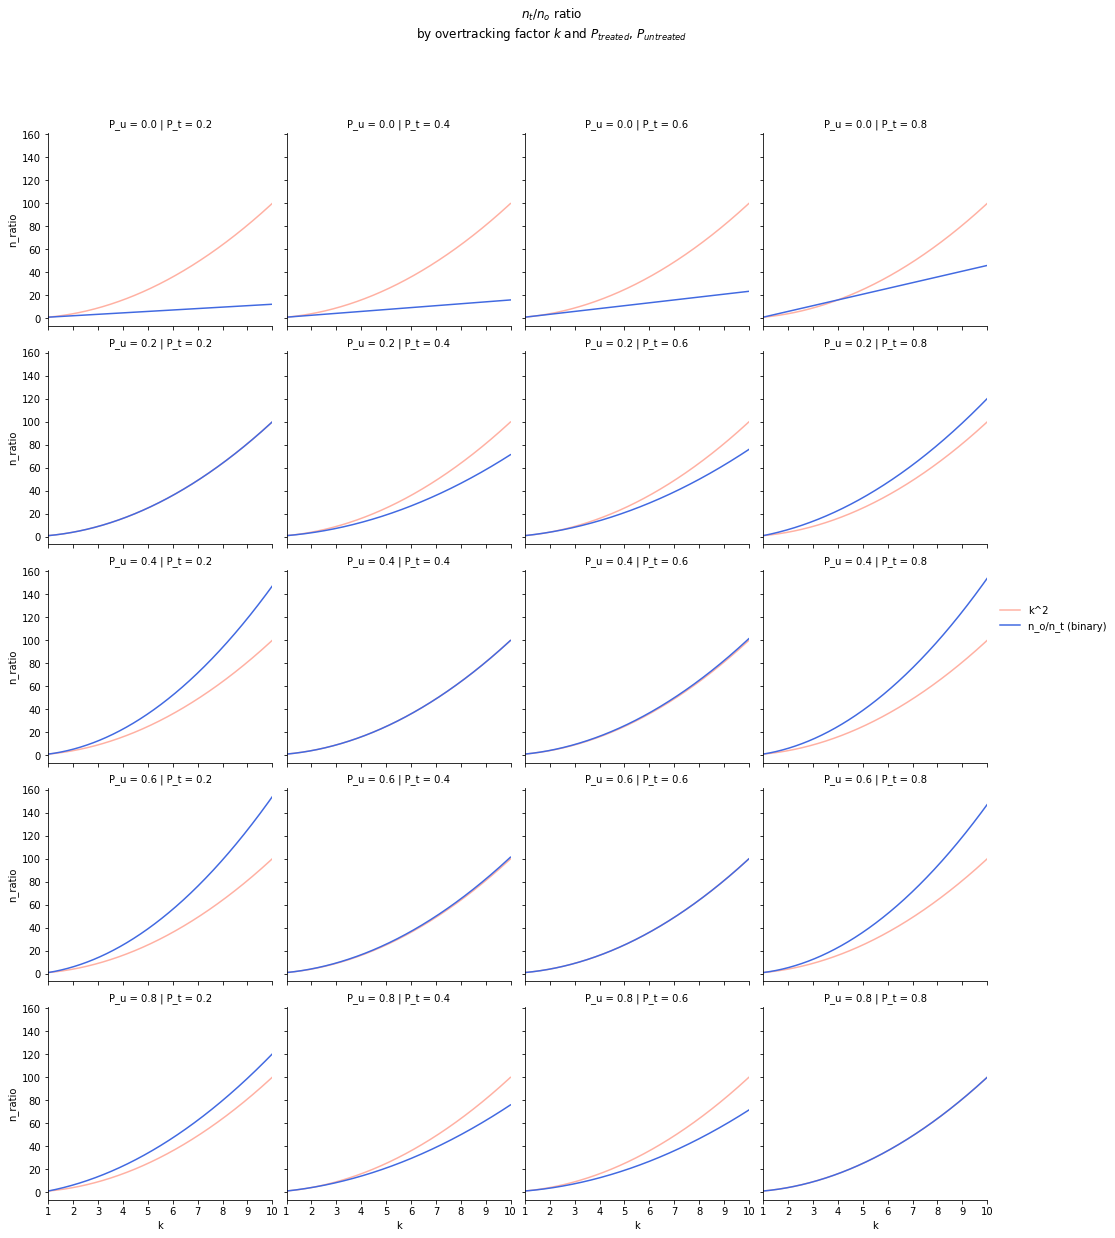

In [5]:
g = sns.FacetGrid(data = df.sort_values(by='k'),
                  height=3.5, aspect=1, 
                  col='P_t', row='P_u', 
                 )
g.map(const_line)
g.map(sns.lineplot, 'k', 'n_ratio', color='royalblue', label="n_o/n_t (binary)")
g.add_legend()
g.set(
    xticks=[k for k in range(max_k+1)], 
    xlim=(1,max_k)
)
plt.subplots_adjust(top=0.88) 
g.fig.suptitle("$n_t/n_o$ ratio \nby overtracking factor $k$ and $P_{treated}$, $P_{untreated}$")
plt.savefig('u_t_plot.png')

## Simulate sampled normal distribution as a function of k^factor

In [162]:
### Simulations
sample_size = 1000000
n_trials = 529490 
# https://et.booking.com/powercalculator?testType=gTest&calculateProp=sample&view_sample=529490&view_base=5&view_impact=3&view_impactRel=3&view_impactAbs=0.15&view_power=80&view_falsePosRate=10&view_sdRate=10&view_runtime=6&view_visitorsPerDay=100000&view_nonInfThresholdAbs=26.40&view_nonInfThresholdRel=2.40&view_variants=1&view_comparisonMode=all&view_trafficMode=daily&lockedField=days&view_selected=relative&nonInferiority_enabled=false

p_t_b = 0.05
p_t_v = 0.0515
p_u = (p_t_v + p_t_b)/2 # 0.05

sample_untreated = np.random.binomial(n=n_trials, p=p_u, size=sample_size)
sample_treated_base = np.random.binomial(n=n_trials, p=p_t_b, size=sample_size)
sample_treated_variant = np.random.binomial(n=n_trials, p=p_t_v, size=sample_size)

# sample_untreated = np.random.normal(10, 1, size=sample_size)
# sample_treated_base = np.random.normal(10.1, 1, size=sample_size)
# sample_treated_variant = np.random.normal(10.2, 1, size=sample_size)

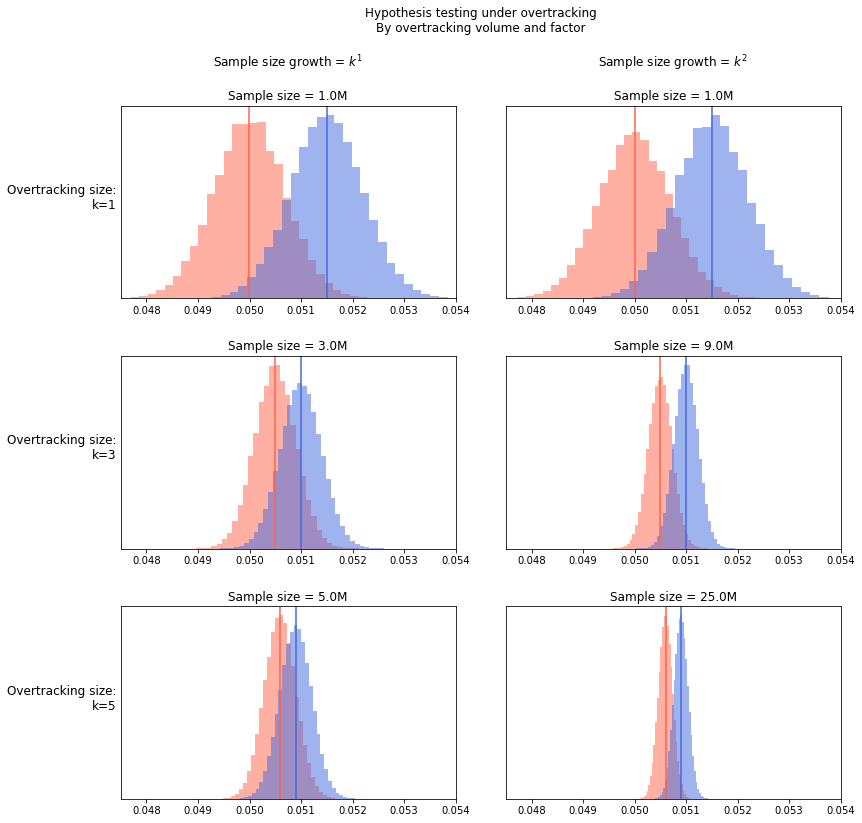

In [7]:
fig, axs = plt.subplots(3,2,figsize=(12.5,12.5))
plt.subplots_adjust(
    left=0.1, 
    right=0.9, 
    bottom=0.1,
    top=0.87, 
    wspace=0.15, 
    hspace=0.3
)

np.random.seed(1)
for k_factor in range(1,3):
    for axi, k in zip(range(3), range(1,6,2)):
        sample_treated_base_o = np.random.binomial(n=n_trials*k**k_factor, p=(p_t_b + (k-1)*p_u)/k, size=sample_size) / (n_trials*k**k_factor)
        sample_treated_variant_o = np.random.binomial(n=n_trials*k**k_factor, p=(p_t_v + (k-1)*p_u)/k, size=sample_size) / (n_trials*k**k_factor)
        axs[axi,k_factor-1].hist(sample_treated_base_o, bins=40, alpha=0.5, color='tomato')
        axs[axi,k_factor-1].hist(sample_treated_variant_o, bins=40, alpha=0.5, color='royalblue')
        axs[axi,k_factor-1].axvline(x=sample_treated_base_o.mean(), color='tomato')
        axs[axi,k_factor-1].axvline(x=sample_treated_variant_o.mean(), color='royalblue')
        if k == 1:
            axs[axi,k_factor-1].set_title(f'Sample size growth = $k^{k_factor}$\n\nSample size = {((sample_size*(k**k_factor))/1000000)}M') # \nP-value={np.round(pval,4)}
        else:
            axs[axi,k_factor-1].set_title(f'Sample size = {((sample_size*(k**k_factor))/1000000)}M') # \nP-value={np.round(pval,4)}
        axs[axi,k_factor-1].set_xlim(p_t_b - 0.0025, p_t_v + 0.0025)
        axs[axi,k_factor-1].set_yticks([])
        axs[axi,0].set_ylabel(f'Overtracking size:\nk={k}', rotation=0, size='large', horizontalalignment='right', y=0.45)

fig.suptitle('Hypothesis testing under overtracking\nBy overtracking volume and factor')
plt.savefig('dist_plot.png')

## Simulate changes in sampled p-values with changes in k^factor

In [26]:
sample_size = int(9368 / 2)
# https://et.booking.com/powercalculator?testType=gTest&calculateProp=sample&view_sample=9368&view_base=5&view_impact=20&view_impactRel=20&view_impactAbs=1.0000000000000002&view_power=80&view_falsePosRate=20&view_sdRate=10&view_runtime=937&view_visitorsPerDay=10&view_nonInfThresholdAbs=26.40&view_nonInfThresholdRel=2.40&view_variants=1&view_comparisonMode=all&view_trafficMode=daily&lockedField=days&view_selected=relative&nonInferiority_enabled=false
n_trials = 1
p_u = 0.5
p_t_b = 0.5
p_t_v = 0.55

sample_untreated = np.random.binomial(n=n_trials, p=p_u, size=sample_size)
sample_treated_base = np.random.binomial(n=n_trials, p=p_t_b, size=sample_size)
sample_treated_variant = np.random.binomial(n=n_trials, p=p_t_v, size=sample_size)

In [33]:
k_vals = [k/10 for k in range(10,70,1)]
k_factor_vals = [k_factor/10 for k_factor in range(10,30,10)]
bootstraps = [i for i in range(500)]

df = pd.DataFrame([i for i in product(bootstraps,k_factor_vals, k_vals)])
df.columns = ['bootstrap','k_factor','k']
df.tail()

,bootstrap,k_factor,k
59995,499,2.0,6.5
59996,499,2.0,6.6
59997,499,2.0,6.7
59998,499,2.0,6.8
59999,499,2.0,6.9


In [ ]:
df['p_value'] = df.apply(
    lambda x: get_pval_per_k(
        x['k'],
        x['k_factor'], 
        n_trials=n_trials, 
        p_t_b=p_t_b , 
        p_t_v=p_t_v, 
        p_u=p_u, 
        sample_size=sample_size
    ), axis=1)


In [ ]:
significance_level = 0.1

df['fn'] = df['p_value'] >= significance_level
df.groupby('k_factor')['fn'].mean()

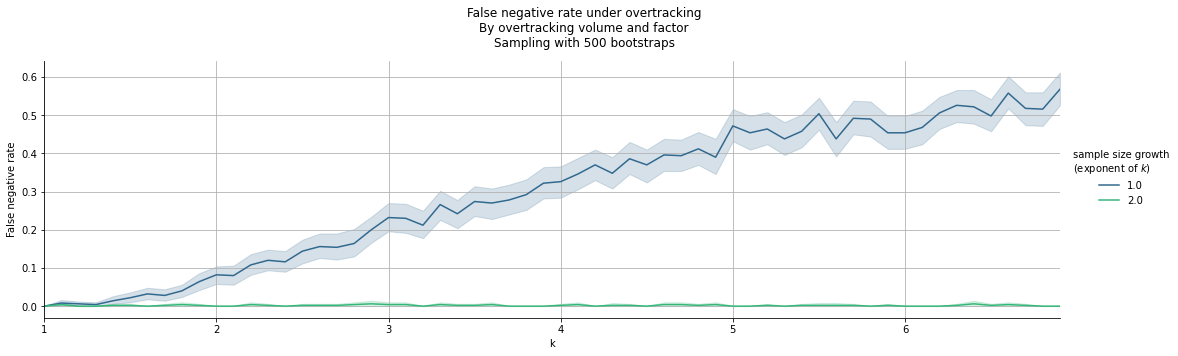

In [39]:
g = sns.FacetGrid(data = df.reset_index(),
                  height=5, aspect=3, 
                  hue='k_factor', palette='viridis'
                 )
g.map(sns.lineplot, 'k', 'fn')
g.add_legend(title="sample size growth\n(exponent of $k$)")
g.set(
    xlim=(1,max(df['k'])),
    ylabel='False negative rate',
)
plt.grid()
plt.subplots_adjust(top=0.83) 
g.fig.suptitle(f"False negative rate under overtracking\nBy overtracking volume and factor\nSampling with {len(bootstraps)} bootstraps")
plt.savefig('false_neg_plot.png')

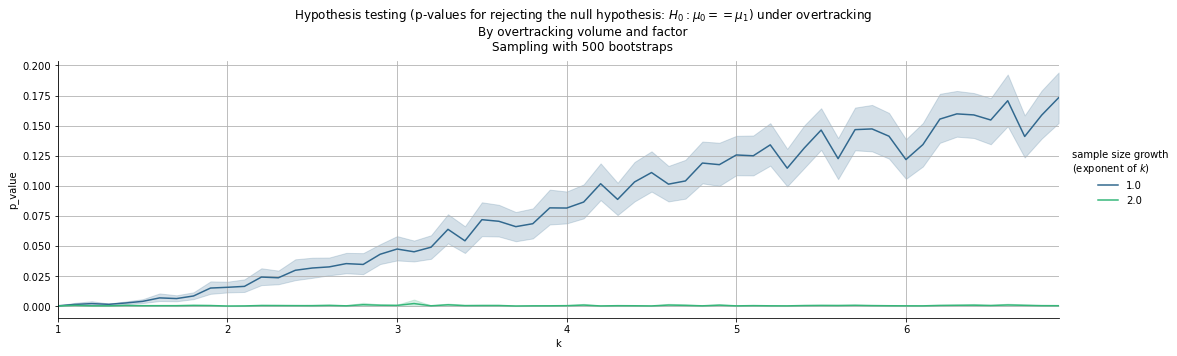

In [37]:
g = sns.FacetGrid(data = df.reset_index(),
                  height=5, aspect=3, 
                  hue='k_factor', palette='viridis'
                 )
g.map(sns.lineplot, 'k', 'p_value')
g.add_legend(title="sample size growth\n(exponent of $k$)")
g.set(
    xlim=(1,max(df['k'])),
#     ylim=(0,0.4)
)
plt.grid()
plt.subplots_adjust(top=0.83) 
g.fig.suptitle(f"Hypothesis testing (p-values for rejecting the null hypothesis: $H_0: \mu_0 == \mu_1$) under overtracking\nBy overtracking volume and factor\nSampling with {len(bootstraps)} bootstraps")
plt.savefig('pval_plot.png')

In [38]:
def q10(x):
    return x.quantile(0.10)
def q50(x):
    return x.quantile(0.5)
def q75(x):
    return x.quantile(0.75)

df_stat = df.groupby(['k','k_factor']).agg({'p_value':['mean','std', q10, q50, q90]}).reset_index()
df_stat.columns = ['k', 'k_factor', 'mean','std', 'q25', 'q50', 'q75']

df_plot = df_stat[df_stat['k_factor']==1]
fig, ax = plt.subplots(figsize=(15,5))
ax.fill_between(x=df_stat.loc[df_stat['k_factor']==1,'k'], y1=df_stat.loc[df_stat['k_factor']==1,'q25'], y2=df_stat.loc[df_stat['k_factor']==1,'q75'], alpha=0.5, color='tomato')
ax.fill_between(x=df_stat.loc[df_stat['k_factor']==2,'k'], y1=df_stat.loc[df_stat['k_factor']==2,'q25'], y2=df_stat.loc[df_stat['k_factor']==2,'q75'], alpha=0.5, color='skyblue')


NameError: name 'q90' is not defined

## Simulations on negative binomial distribution

In [12]:
### Simulations
sample_size = 1000000
n_trials = 100000
p_u = 0.05
p_t_b = 0.05
p_t_v = 0.05075

sample_untreated = np.random.negative_binomial(n=n_trials, p=p_u, size=sample_size) / (n_trials) 
sample_treated_base = np.random.negative_binomial(n=n_trials, p=p_t_b, size=sample_size) / (n_trials) 
sample_treated_variant = np.random.negative_binomial(n=n_trials, p=p_t_v, size=sample_size) / (n_trials) 

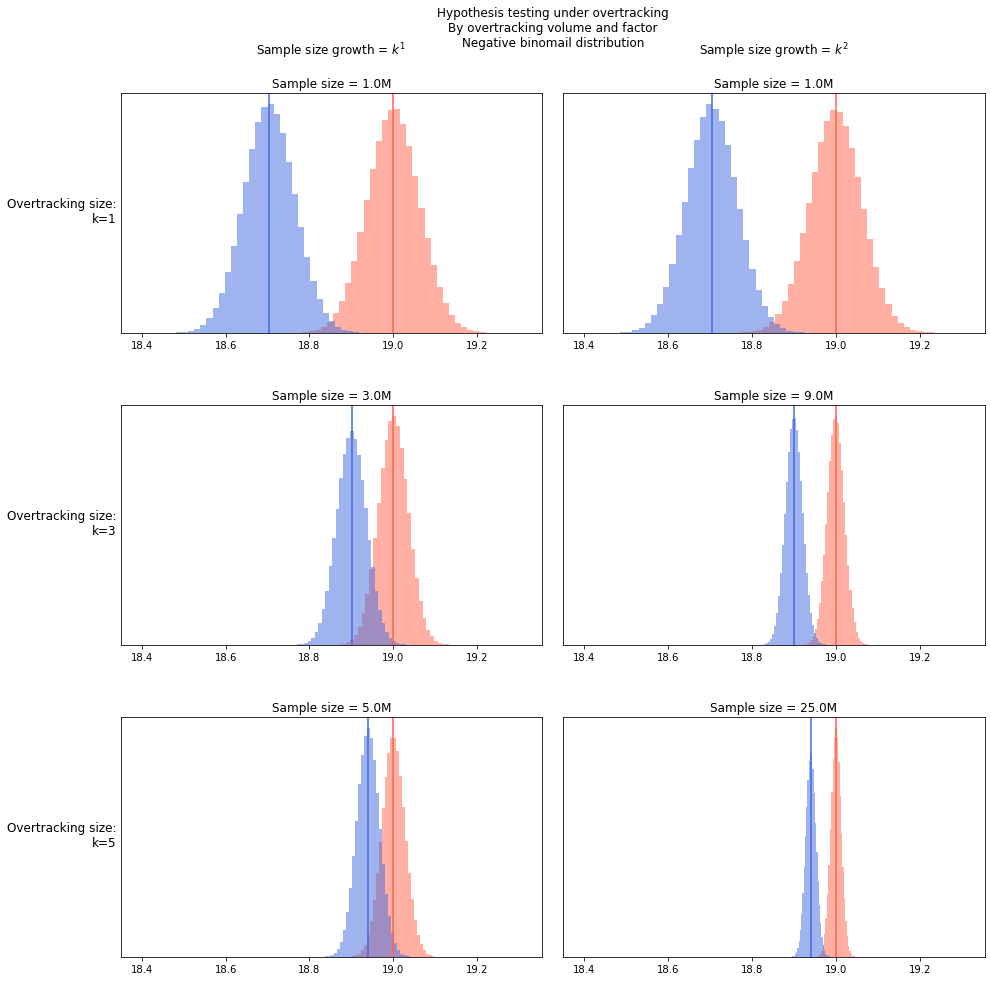

In [13]:
fig, axs = plt.subplots(3,2,figsize=(15,15))
plt.subplots_adjust(
    left=0.1, 
    right=0.9, 
    bottom=0.1,
    top=0.9, 
    wspace=0.05, 
    hspace=0.3
)

np.random.seed(1)
for k_factor in range(1,3):
    for axi, k in zip(range(3), range(1,6,2)):
        
        sample_treated_base_o = np.random.negative_binomial(n=n_trials*k**k_factor, p=(p_t_b + (k-1)*p_u)/k, size=sample_size)  / (n_trials*k**k_factor)
        sample_treated_variant_o = np.random.negative_binomial(n=n_trials*k**k_factor, p=(p_t_v + (k-1)*p_u)/k, size=sample_size)  / (n_trials*k**k_factor)
        axs[axi,k_factor-1].hist(sample_treated_base_o, bins=40, alpha=0.5, color='tomato')
        axs[axi,k_factor-1].hist(sample_treated_variant_o, bins=40, alpha=0.5, color='royalblue')
        axs[axi,k_factor-1].axvline(x=sample_treated_base_o.mean(), color='tomato')
        axs[axi,k_factor-1].axvline(x=sample_treated_variant_o.mean(), color='royalblue')
        if k == 1:
            axs[axi,k_factor-1].set_title(f'Sample size growth = $k^{k_factor}$\n\nSample size = {((sample_size*(k**k_factor))/1000000)}M') # \nP-value={np.round(pval,4)}
        else:
            axs[axi,k_factor-1].set_title(f'Sample size = {((sample_size*(k**k_factor))/1000000)}M') # \nP-value={np.round(pval,4)}
        axs[axi,k_factor-1].set_xlim(sample_treated_base.mean() - 0.65, sample_treated_variant.mean() + 0.65)
        axs[axi,k_factor-1].set_yticks([])
        axs[axi,0].set_ylabel(f'Overtracking size:\nk={k}', rotation=0, size='large', horizontalalignment='right', y=0.45)
        

fig.suptitle('Hypothesis testing under overtracking\nBy overtracking volume and factor\nNegative binomail distribution')
plt.savefig('dist_plot_neg_binomial.png')

## Simulations on Poisson distribution

In [14]:
### Simulations
sample_size = 1000000
n_trials = 100000
p_u = 0.05
p_t_b = 0.05
p_t_v = 0.053


sample_untreated = np.random.poisson(lam=n_trials*p_u, size=sample_size)
sample_treated_base = np.random.poisson(lam=n_trials*p_t_b, size=sample_size)
sample_treated_variant = np.random.poisson(lam=n_trials*p_t_v, size=sample_size)

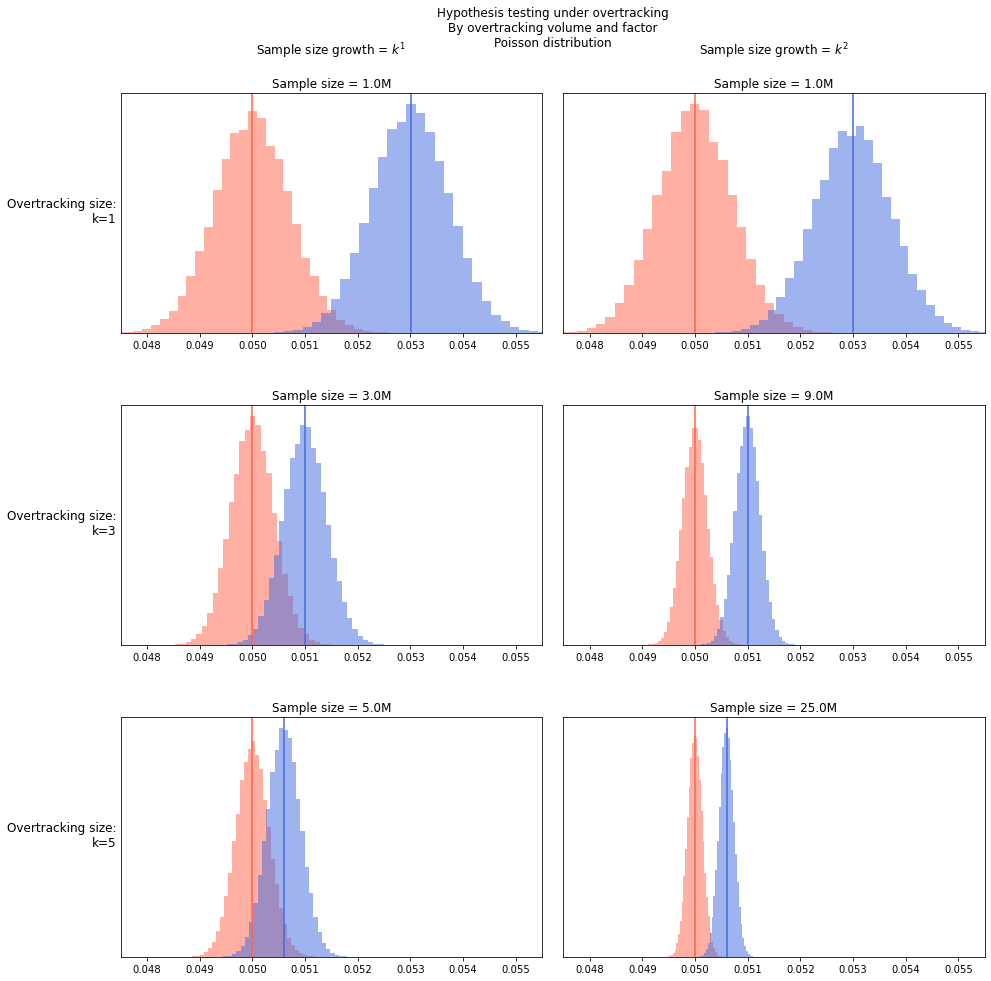

In [15]:
fig, axs = plt.subplots(3,2,figsize=(15,15))
plt.subplots_adjust(
    left=0.1, 
    right=0.9, 
    bottom=0.1,
    top=0.9, 
    wspace=0.05, 
    hspace=0.3
)

np.random.seed(1)
for k_factor in range(1,3):
    for axi, k in zip(range(3), range(1,6,2)):
        
        sample_treated_base_o = np.random.poisson(lam=(n_trials*k**k_factor)*(p_t_b + (k-1)*p_u)/k, size=sample_size) / (n_trials*k**k_factor)
        sample_treated_variant_o = np.random.poisson(lam=(n_trials*k**k_factor)*(p_t_v + (k-1)*p_u)/k, size=sample_size) / (n_trials*k**k_factor)
        axs[axi,k_factor-1].hist(sample_treated_base_o, bins=40, alpha=0.5, color='tomato')
        axs[axi,k_factor-1].hist(sample_treated_variant_o, bins=40, alpha=0.5, color='royalblue')
        axs[axi,k_factor-1].axvline(x=sample_treated_base_o.mean(), color='tomato')
        axs[axi,k_factor-1].axvline(x=sample_treated_variant_o.mean(), color='royalblue')
        if k == 1:
            axs[axi,k_factor-1].set_title(f'Sample size growth = $k^{k_factor}$\n\nSample size = {((sample_size*(k**k_factor))/1000000)}M') 
        else:
            axs[axi,k_factor-1].set_title(f'Sample size = {((sample_size*(k**k_factor))/1000000)}M') 
        axs[axi,k_factor-1].set_xlim(p_t_b - 0.0025, p_t_v + 0.0025)
        axs[axi,k_factor-1].set_yticks([])
        axs[axi,0].set_ylabel(f'Overtracking size:\nk={k}', rotation=0, size='large', horizontalalignment='right', y=0.45)

fig.suptitle('Hypothesis testing under overtracking\nBy overtracking volume and factor\nPoisson distribution')
plt.savefig('dist_plot_poisson.png')

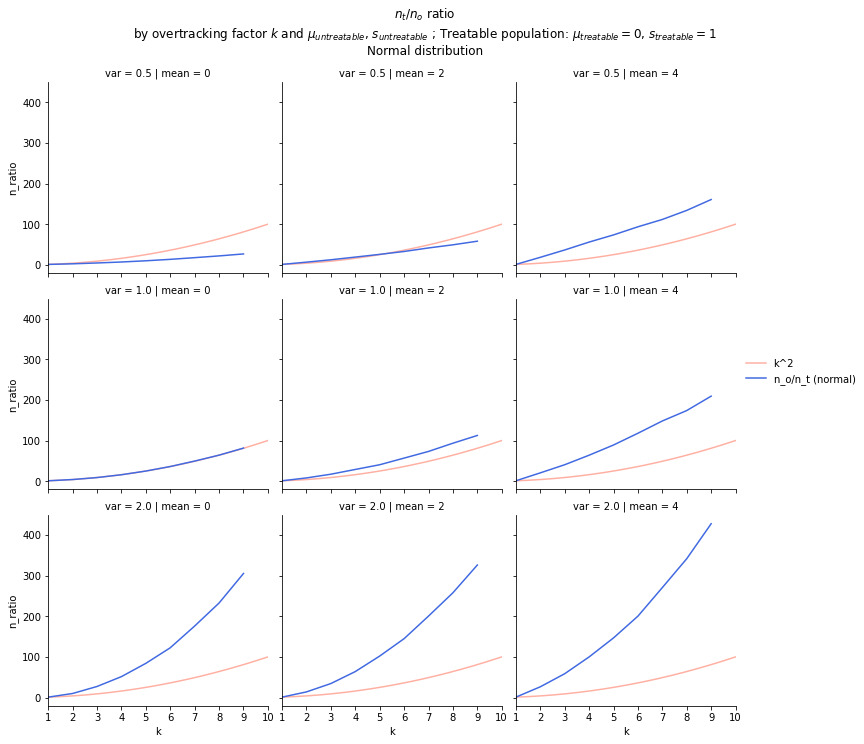

In [23]:
## normals
max_k = 10
sample_size = 10000

mean_vals = [i for i in [0,2,4]]
var_vals = [i for i in [0.5,1,2]]
k_vals = [i for i in range(1,max_k,1)]

results = []
for m,v in product(mean_vals, var_vals):
    for k in k_vals:
        sample_treated_base = np.random.normal(loc=0, scale=1 , size=sample_size)
        sample_untreated_base = np.random.normal(loc=m, scale=v ,size=sample_size*int(k-1))
        sample_overtracked_base = np.concatenate((sample_treated_base,sample_untreated_base))
        
        v_t = np.var(sample_treated_base)
        v_u = np.var(sample_untreated_base)
        v_o = np.var(sample_overtracked_base)
        
        n_vals = {
            'mean': m,
            'var': v,
            'k': k,
            'var_t_b': v_t,
            'var_u_b': v_u,
            'var_o_b': v_o,
            'n_ratio': (k**2)*(v_o/v_t)
        }
        results.append(n_vals)
            
df = pd.DataFrame(results)

df.head()

g = sns.FacetGrid(data = df.sort_values(by='k'),
                  height=3.5, aspect=1, 
                  col='mean', row='var', 
                 )
g.map(const_line)
g.map(sns.lineplot, 'k', 'n_ratio', color='royalblue', label="n_o/n_t (normal)")
g.add_legend()
g.set(
    xticks=[k for k in range(max_k+1)], 
    xlim=(1,max_k)
)
plt.subplots_adjust(top=0.88) 
g.fig.suptitle("$n_t/n_o$ ratio \nby overtracking factor $k$ and $\mu_{untreatable}$, $s_{untreatable}$ ; Treatable population: $\mu_{treatable}=0$, $s_{treatable}=1$\nNormal distribution")
plt.savefig('u_t_plot_normal.png')

----

In [17]:
## Poissons
max_k = 10
sample_size = 10000

lambda_vals = [i for i in [2,4,8]]
k_vals = [i for i in range(1,max_k,1)]

results = []
for p_u,p_t in product(lambda_vals, lambda_vals):
    for k in k_vals:
        sample_treated_base = np.random.poisson(lam=p_t, size=sample_size)
        sample_untreated_base = np.random.poisson(lam=p_u, size=sample_size*int(k-1))
        sample_overtracked_base = np.concatenate((sample_treated_base,sample_untreated_base))
        
        v_t = np.var(sample_treated_base)
        v_u = np.var(sample_untreated_base)
        v_o = np.var(sample_overtracked_base)
        
        n_vals = {
            'P_u': p_u,
            'P_t': p_t,
            'k': k,
            'var_t_b': v_t,
            'var_u_b': v_u,
            'var_o_b': v_o,
            'n_ratio': (k**2)*(v_o/v_t)
        }
        results.append(n_vals)
            
df = pd.DataFrame(results)

df.head()

,P_u,P_t,k,var_t_b,var_u_b,var_o_b,n_ratio
0,2,2,1,2.041690,NaN,2.041690,1.000000
1,2,2,2,2.013545,1.995265,2.004410,3.981852
2,2,2,3,1.999278,1.959612,1.972993,8.881677
3,2,2,4,1.988800,1.996294,1.994434,16.045329
4,2,2,5,2.007166,1.993996,1.996640,24.868888


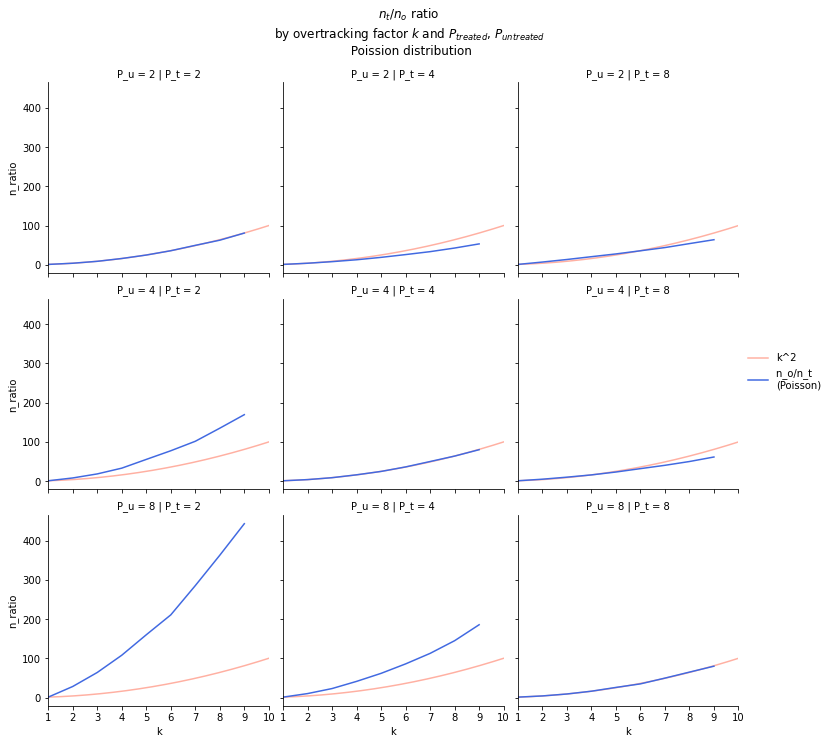

In [18]:
g = sns.FacetGrid(data = df.sort_values(by='k'),
                  height=3.5, aspect=1, 
                  col='P_t', row='P_u', 
                 )
g.map(const_line)
g.map(sns.lineplot, 'k', 'n_ratio', color='royalblue', label="n_o/n_t \n(Poisson)")
g.add_legend()
g.set(
    xticks=[k for k in range(max_k+1)], 
    xlim=(1,max_k)
)
plt.subplots_adjust(top=0.88) 
g.fig.suptitle("$n_t/n_o$ ratio \nby overtracking factor $k$ and $P_{treated}$, $P_{untreated}$\n Poission distribution")
plt.savefig('u_t_plot_poisson.png')

1
2
3
4
5
6
7
8
9
10


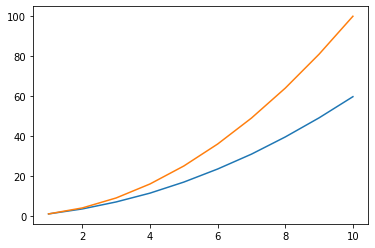

1
2
3
4
5
6
7
8
9
10


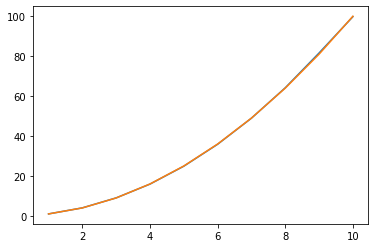

1
2
3
4
5
6
7
8
9
10


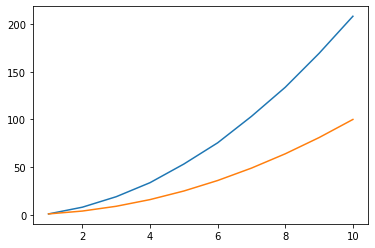

1
2
3
4
5
6
7
8
9
10


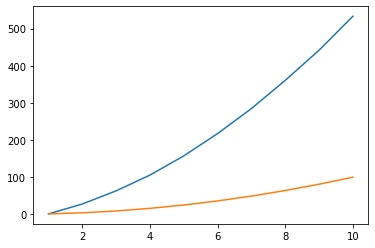

In [19]:
## Poissons
for p_u in [1,2,4,8]:
    sample_size = 100000
    p_t_b = 2
#     p_t_v = 10.5
    n_ratios = []
    for k in range(1,11):
        print(k)
        sample_treated_base = np.random.poisson(lam=p_t_b, size=sample_size)
#         sample_treated_variant = np.random.poisson(lam=p_t_v, size=sample_size)
        sample_untreated_base = np.random.poisson(lam=p_u, size=sample_size*(k-1))
#         sample_untreated_variant = np.random.poisson(lam=p_u, size=sample_size*(k-1))

        sample_overtracked_base = np.concatenate((sample_treated_base,sample_untreated_base))
#         sample_overtracked_variant = np.concatenate((sample_treated_variant,sample_untreated_variant))

        var_t_b = np.var(sample_treated_base)
        var_u_b = np.var(sample_untreated_base)
        var_o_b = np.var(sample_overtracked_base)

        n_ratio = (k**2)*(var_o_b/var_t_b)
        n_ratios += [n_ratio]
    plt.plot(range(1,11),n_ratios)
    plt.plot(range(1,11),[x**2 for x in range(1,11)])
    plt.show()

1
2
3
4
5
6
7
8
9
10


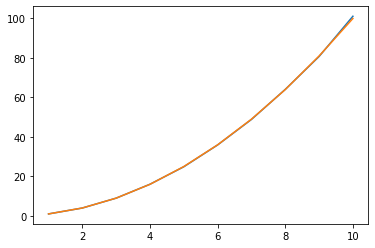

1
2
3
4
5
6
7
8
9
10


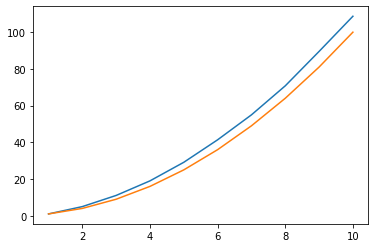

1
2
3
4
5
6
7
8
9
10


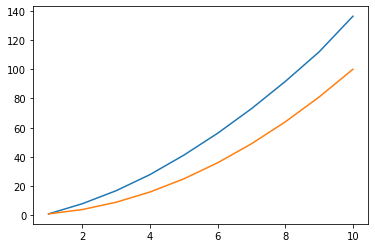

1
2
3
4
5
6
7
8
9
10


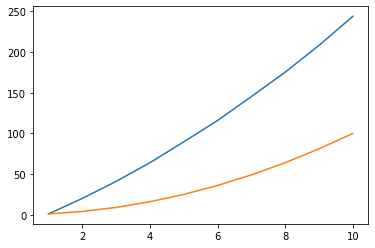

In [20]:
## Normal, fixed var
for p_u in [0,1,2,4]: #nothing until 4 variances away
    sample_size = 100000
    p_t_b = 0
#     p_u = 0
    v_u = 1
    v_t = 1
    n_ratios = []
    for k in range(1,11):
        print(k)
        sample_treated_base = np.random.normal(loc=p_t_b, scale=v_t ,size=sample_size)
        sample_untreated_base = np.random.normal(loc=p_u,  scale=v_u ,size=sample_size*(k-1))
        sample_overtracked_base = np.concatenate((sample_treated_base,sample_untreated_base))

        var_t_b = np.var(sample_treated_base)
        var_u_b = np.var(sample_untreated_base)
        var_o_b = np.var(sample_overtracked_base)

        n_ratio = (k**2)*(var_o_b/var_t_b)
        n_ratios += [n_ratio]
    plt.plot(range(1,11),n_ratios)
    plt.plot(range(1,11),[x**2 for x in range(1,11)])
    plt.show()

1
2
3
4
5
6
7
8
9
10


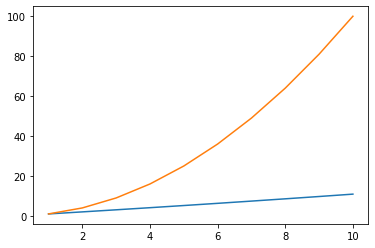

1
2
3
4
5
6
7
8
9
10


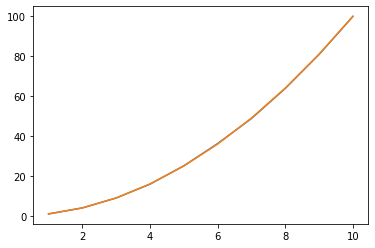

1
2
3
4
5
6
7
8
9
10


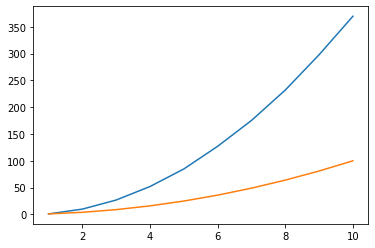

1
2
3
4
5
6
7
8
9
10


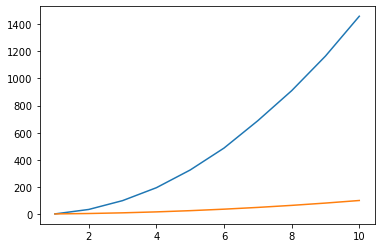

In [21]:
## Normal, fixed mean
for v_u in [.1,1,2,4]:
    sample_size = 100000
    p_t_b = 0
    p_u = 0
    v_t = 1
    n_ratios = []
    for k in range(1,11):
        print(k)
        sample_treated_base = np.random.normal(loc=p_t_b, scale=v_t ,size=sample_size)
        sample_untreated_base = np.random.normal(loc=p_u,  scale=v_u ,size=sample_size*(k-1))
        sample_overtracked_base = np.concatenate((sample_treated_base,sample_untreated_base))

        var_t_b = np.var(sample_treated_base)
        var_u_b = np.var(sample_untreated_base)
        var_o_b = np.var(sample_overtracked_base)

        n_ratio = (k**2)*(var_o_b/var_t_b)
        n_ratios += [n_ratio]
    plt.plot(range(1,11),n_ratios)
    plt.plot(range(1,11),[x**2 for x in range(1,11)])
    plt.show()